# Xe Propellant Storage
Can MOFs confer a benefit for storing Xe? For applications as propellant for a spacecraft, the goal is to minimize the total mass carried into space. To contrast, this mass is composed of:
* for compressed Xe (`cXe`) storage (no MOF, a free-space tank): the xenon needed and the material that composes the tank
* for adsorbed Xe (`aXe`) storage (a tank packed with MOF): the xenon needed, the material that composes the tank *and* the adsorbent material.

The idea is that we can reduce the mass of tank material needed by reducing the storage pressure needed to achieve a given density of Xe. This necessitates us to carry extra mass, the mass of the MOF, though. The question is whether the reduced mass of the tank material outweighs the extra mass of this adsorbent material we need to carry into space.

In [1]:
using PyPlot
using PorousMaterials
using CSV
using DataFrames
using JSON
using Printf

PyPlot.matplotlib.style.use("Solarize_Light2")
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
# rcParams["font.size"] = 16

PyCall.PyDict{PyCall.PyAny,PyCall.PyAny,true} with 299 entries:
  "backend"                => "agg"
  "backend_fallback"       => true
  "webagg.port"            => 8988
  "webagg.address"         => "127.0.0.1"
  "webagg.open_in_browser" => true
  "webagg.port_retries"    => 50
  "toolbar"                => "toolbar2"
  "datapath"               => "C:\\Users\\Owner\\.julia\\conda\\3\\lib\\site-pa…
  "interactive"            => false
  "timezone"               => "UTC"
  "verbose.level"          => "silent"
  "verbose.fileo"          => "sys.stdout"
  "lines.linewidth"        => 2.0
  "lines.linestyle"        => "-"
  "lines.color"            => "C0"
  "lines.marker"           => "None"
  "lines.markerfacecolor"  => "auto"
  "lines.markeredgecolor"  => "auto"
  "lines.markeredgewidth"  => 1.0
  "lines.markersize"       => 6.0
  "lines.antialiased"      => true
  "lines.dash_joinstyle"   => "round"
  "lines.solid_joinstyle"  => "round"
  "lines.dash_capstyle"    => "butt"
  "lines.solid

temperature `T` in the atmosphere

In [2]:
const T = 298.0 # K

298.0

universal gas constant

In [3]:
const R = 8.3144598e-5 # m³-bar/(K-mol)

8.3144598e-5

Moles desired of xenon propellant. [Source](https://doi.org/10.2514/6.2000-3677) for typical amount of Xe to bring into space: 89 kg

In [4]:
const mol_desired_propellant = 1000 # mol

1000

Convert moles propellant to mass propellant for tankage fraction.

In [5]:
mass_desired_propellant = mol_desired_propellant * read_atomic_masses()[:Xe] / 1000 # kg

131.293

range of storage pressures considered

In [6]:
const P = 10 .^ range(-2.0, stop=log10(200.), length=501)[2:end]; # bar

properties of the tank material

We model the pressure vessel as a thin-walled pressure vessel.

We list the density `ρ` and yield strength `σ` of the tank material below.

In [7]:
# # Kevlar 49 Source: http://www.mse.mtu.edu/~drjohn/my4150/props.html
# const ρ_tank_material = 1470.0 # kg/m³
# const σ_tank_material = 28000.0 # bar

# titanium
const ρ_tank_material = 4506.0 # kg/m³
const σ_tank_material = 1400.0 # bar

1400.0

## Compressed xenon (`cXe`) storage
we model xenon with the van der Waals equation of state. We first explore how the van der Waals gas differs from the ideal gas.

In [8]:
# ideal gas density
ρ_ideal_gas = P / (R * T) # mol / m³

ρ_vdw_gas = zeros(length(P))
xe = VdWFluid(:Xe)

for (i, p_i) in enumerate(P)
    props = calculate_properties(xe, T, p_i, verbose=false)
    ρ_vdw_gas[i] = props["density (mol/m³)"]
end
    
figure()
plot(P, ρ_ideal_gas, color="green", label="ideal gas")
plot(P, ρ_vdw_gas, color="orange", label="van der Waals gas")
xlabel("pressure [bar]")
ylabel("density [mol / m\$^3\$]")
legend()
title("Xenon ρ(P)")
#savefig("Xenon Ideal Gas vs. van der Waals Gas Density.pdf", format="pdf")

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = VdWFluid(::Symbol) at EOS.jl:151
└ @ PorousMaterials C:\Users\Owner\.julia\packages\PorousMaterials\0VxH9\src\EOS.jl:151
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = VdWFluid(::Symbol) at EOS.jl:154
└ @ PorousMaterials C:\Users\Owner\.julia\packages\PorousMaterials\0VxH9\src\EOS.jl:154


ArgumentError: ArgumentError: unable to check bounds for indices of type Missing

The volume of the tank must be equal to the volume of propellant (of course). Since we have the density of the propellant at each pressure, we thus know the volume of the tank at each choice of storage pressure.

In [9]:
V_cXe_tank = mol_desired_propellant ./ ρ_vdw_gas; # m³

Knowing the density of the propellant and volume of tank at each pressure yields the mass of gas stored in a compressed tank.

In [10]:
m_cXe_gas = ρ_vdw_gas .* V_cXe_tank * read_atomic_masses()[:Xe] / 1000; # kg

Assuming the tank is spherical, we can calculate the radius of the tank for each choice of storage pressure.

In [11]:
r_cXe_tank = (V_cXe_tank * 3 / (4 * π)) .^ (1 / 3); # m

We apply the thin-walled tank stress model to obtain the minimum wall thickness required to contain the pressure of the compressed xenon. Thickness is found using the free-body diagram of a spherical, thin-walled tank. By taking the force of the fluid over a cross-sectional area ($P \pi  r ^ 2$) set equal to the force of the tank walls over the circumference, including the yield strength and thickness of the wall ($2 \pi  r \sigma  t$). We then isolate $t$ to solve for the thickness.

\begin{equation}
2 \pi  r \sigma  t=P \pi  r ^ 2
\end{equation}

In [12]:
t_cXe_tank = P .* r_cXe_tank / (2 * σ_tank_material); # tank wall thickness (m)

The mass of the tank can be found using the surface area of sphere, the thickness of the sphere, and the density of the material.

In [13]:
m_cXe_tank_material = ρ_tank_material * 4 * π * r_cXe_tank .^ 2 .* t_cXe_tank; # kg

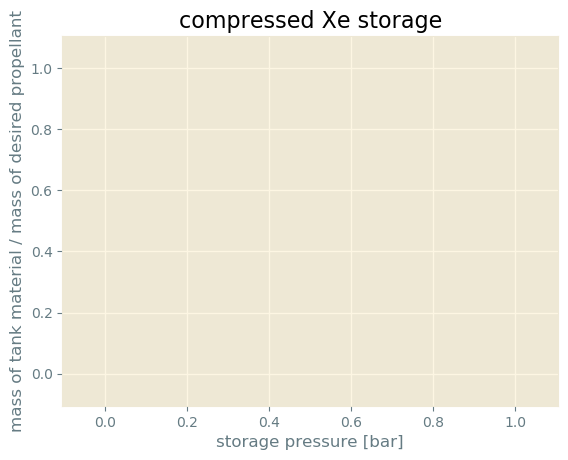

PyObject Text(0.5, 1, 'compressed Xe storage')

In [14]:
cXe_minimum_index = argmin(m_cXe_tank_material ./ mass_desired_propellant)

figure()
plot(P, m_cXe_tank_material ./ mass_desired_propellant
    , color="C0", lw=3)
scatter(P[cXe_minimum_index], (m_cXe_tank_material ./ m_cXe_gas)[cXe_minimum_index], color="r", zorder=999)
xlabel("storage pressure [bar]")
ylabel("mass of tank material / mass of desired propellant")
title("compressed Xe storage")
#savefig("Xenon van der Waals Gas in Titanium.pdf", format="pdf")

## Adsorbed xenon `aXe` storage

### View isotherms

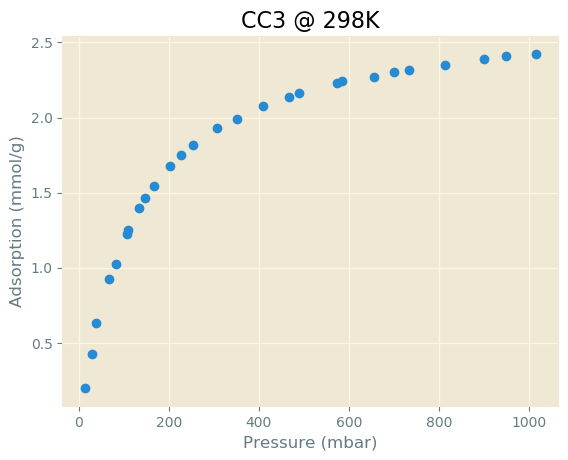

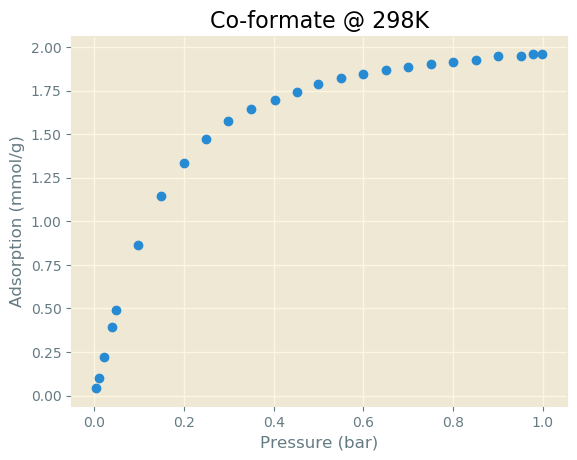

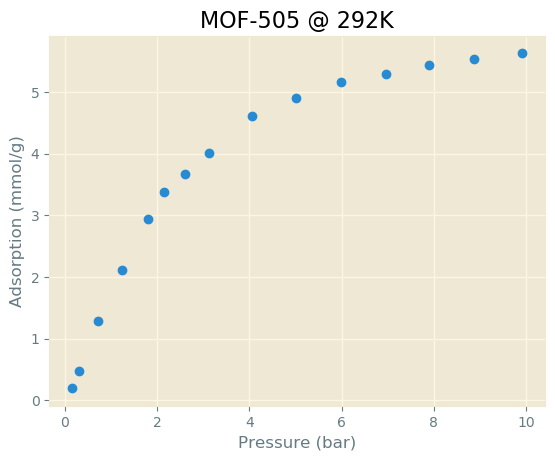

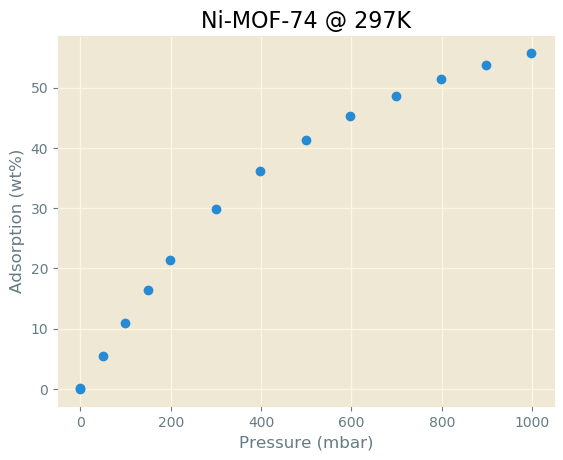

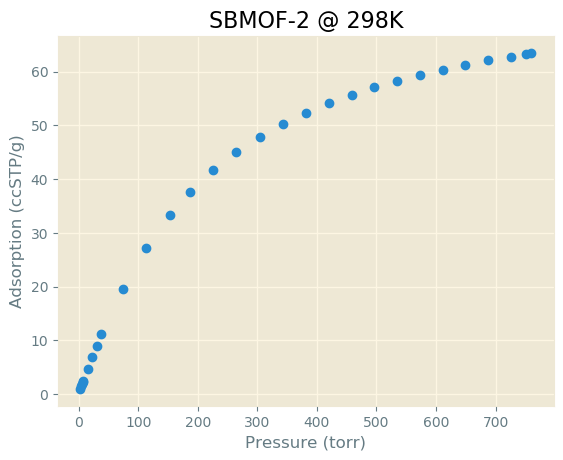

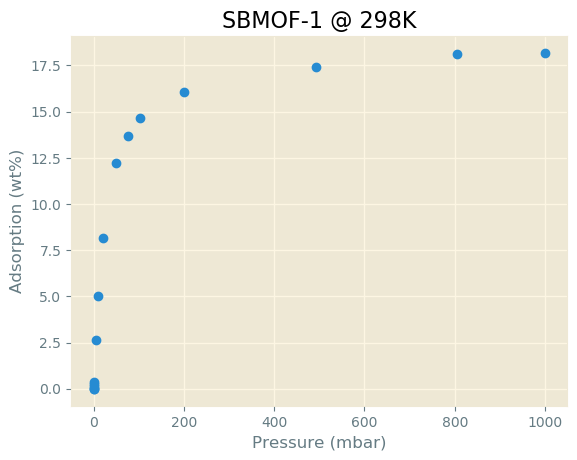

PyObject Text(25.000000000000007, 0.5, 'Adsorption (wt%)')

In [15]:
df_CC3 = CSV.read(joinpath(pwd(), "data", "isotherms", "CC3_298K.csv"))
figure()
scatter(df_CC3[!, Symbol("P(mbar)")], df_CC3[!, Symbol("L(mmol/g)")])
title("CC3 @ 298K")
xlabel("Pressure (mbar)")
ylabel("Adsorption (mmol/g)")

df_CoFormate = CSV.read(joinpath(pwd(), "data", "isotherms", "Co_formate_298K.csv"))
figure()
scatter(df_CoFormate[!, Symbol("P(bar)")], df_CoFormate[!, Symbol("L(mmol/g)")])
title("Co-formate @ 298K")
xlabel("Pressure (bar)")
ylabel("Adsorption (mmol/g)")

df_MOF505 = CSV.read(joinpath(pwd(), "data", "isotherms", "MOF_505_292K.csv"))
figure()
scatter(df_MOF505[!, Symbol("P(bar)")], df_MOF505[!, Symbol("Adsorption(mmol/g)")])
title("MOF-505 @ 292K")
xlabel("Pressure (bar)")
ylabel("Adsorption (mmol/g)")

df_NiMOF74 = CSV.read(joinpath(pwd(), "data", "isotherms", "Ni_MOF_74_297K.csv"))
figure()
scatter(df_NiMOF74[!, Symbol("P(mbar)")], df_NiMOF74[!, Symbol("PercentMass")])
title("Ni-MOF-74 @ 297K")
xlabel("Pressure (mbar)")
ylabel("Adsorption (wt%)")

df_SBMOF2 = CSV.read(joinpath(pwd(), "data", "isotherms", "SBMOF_2_298K.csv"))
figure()
scatter(df_SBMOF2[!, Symbol("P(torr)")][1:29], df_SBMOF2[!, Symbol("L(ccSTP/g)")][1:29])
title("SBMOF-2 @ 298K")
xlabel("Pressure (torr)")
ylabel("Adsorption (ccSTP/g)")

df_SBMOF1 = CSV.read(joinpath(pwd(), "data", "isotherms", "SBMOF_1_298K.csv"))
figure()
scatter(df_SBMOF1[!, Symbol("P(mbar)")], df_SBMOF1[!, Symbol("PercentMass")])
title("SBMOF-1 @ 298K")
xlabel("Pressure (mbar)")
ylabel("Adsorption (wt%)")


Non-saturating isotherms: FMOF-Cu, HKUST-1, IRMOF-1.

find crystal density

In [16]:
# read in isotherms
isotherms = readdir(joinpath(pwd(), "data", "isotherms"))
crystals = readdir(joinpath(pwd(), "data", "crystals"))

# find crystal density
df_ρ = Dict{Symbol, Float64}()

function Base.basename(path::String, suffix::String)
    (n,e) = splitext(basename(path))
    suffix==e ? n : path
end

for crystal in crystals
    frame = Framework(crystal)
    strip_numbers_from_atom_labels!(frame)
    df_ρ[Symbol(Base.basename(crystal, ".cif"))] = crystal_density(frame) # kg/m³
end

df_ρ

Dict{Symbol,Float64} with 7 entries:
  Symbol("CROFOUR-1-Ni") => 1116.92
  Symbol("MOF-505")      => 926.618
  :CC3                   => 973.281
  Symbol("SBMOF-1")      => 1570.4
  Symbol("Ni-MOF-74")    => 1194.12
  Symbol("Co-formate")   => 1821.5
  Symbol("SBMOF-2")      => 1191.92

Convert isotherms to same units

In [36]:
dict_isotherms= Dict{AbstractString, DataFrame}()

# convert to common units: P (bar) and Adsorption (mol/m³)
df_CC3 = CSV.read(joinpath(pwd(), "data", "isotherms", "CC3_298K.csv"))
df_CC3[!, Symbol("P(bar)")] = df_CC3[!, Symbol("P(mbar)")] / 1000; # bar
df_CC3[!, :mol_m3] = df_CC3[!, Symbol("L(mmol/g)")] * df_ρ[Symbol("CC3")] # mol/m^3
dict_isotherms["CC3"] = df_CC3

df_Co_formate = CSV.read(joinpath(pwd(), "data", "isotherms", "Co_formate_298K.csv"))
df_Co_formate[!, :mol_m3] = df_Co_formate[!, Symbol("L(mmol/g)")] * df_ρ[Symbol("Co-formate")]; # mol Xe/m³ MOF
dict_isotherms["Co-formate"] = df_Co_formate

df_MOF_505 = CSV.read(joinpath(pwd(), "data", "isotherms", "MOF_505_292K.csv"))
df_MOF_505[!, :mol_m3] = df_MOF505[!, Symbol("Adsorption(mmol/g)")] * df_ρ[Symbol("MOF-505")];# mol Xe/m³ MOF
dict_isotherms["MOF-505"] = df_MOF_505

df_Ni_MOF_74 = CSV.read(joinpath(pwd(), "data", "isotherms", "Ni_MOF_74_297K.csv"))
df_Ni_MOF_74[!, Symbol("P(bar)")] = df_Ni_MOF_74[!, Symbol("P(mbar)")] / 1000; # bar
df_Ni_MOF_74[!, :mol_m3] = df_Ni_MOF_74[!, :PercentMass] / 100.0 * 1000.0 * df_ρ[Symbol("Ni-MOF-74")] / read_atomic_masses()[:Xe]; # mol Xe/m³ MOF
dict_isotherms["Ni-MOF-74"] = df_Ni_MOF_74

df_SBMOF_1 = CSV.read(joinpath(pwd(), "data", "isotherms", "SBMOF_1_298K.csv"))
df_SBMOF_1[!, Symbol("P(bar)")] = df_SBMOF_1[!, Symbol("P(mbar)")] / 1000; # bar
# mass % = (measured mass -  dry sample mass) / (dry sample mass) * 100.
# (g Xe / g MOF) * (1000 g MOF/ 1 kg MOF) * (ρ_MOF kg MOF/m³ MOF) * (1 mol Xe/ MW g Xe)
df_SBMOF_1[!, :mol_m3] = df_SBMOF_1[!, :PercentMass] / 100.0 * 1000.0 * df_ρ[Symbol("SBMOF-1")] / read_atomic_masses()[:Xe]; # mol Xe/m³ MOF  
dict_isotherms["SBMOF-1"] = df_SBMOF_1

df_SBMOF_2 = CSV.read(joinpath(pwd(), "data", "isotherms", "SBMOF_2_298K.csv"))
df_SBMOF_2[!, Symbol("P(bar)")] = df_SBMOF_2[!, Symbol("P(torr)")] / 750.062
df_SBMOF_2[!, :mol_m3] = df_SBMOF_2[!, Symbol("L(ccSTP/g)")] / 22.4 * df_ρ[Symbol("SBMOF-2")];
dict_isotherms["SBMOF-2"] = df_SBMOF_2

df_CROFOUR_1_Ni = CSV.read(joinpath(pwd(), "data", "isotherms", "CROFOUR_1_Ni_298K.csv"))
df_CROFOUR_1_Ni[!, Symbol("P(bar)")] =  df_CROFOUR_1_Ni[!, Symbol("P(kPa)")] / 100
df_CROFOUR_1_Ni[!, :mol_m3] = df_CROFOUR_1_Ni[!, Symbol("L(ccSTP/g)")] / 22.4 * df_ρ[Symbol("CROFOUR-1-Ni")];
dict_isotherms["CROFOUR-1-Ni"] = df_CROFOUR_1_Ni

dict_isotherms

Dict{AbstractString,DataFrame} with 7 entries:
  "Ni-MOF-74"    => 14×4 DataFrame…
  "SBMOF-2"      => 39×4 DataFrame…
  "CC3"          => 27×4 DataFrame…
  "CROFOUR-1-Ni" => 234×4 DataFrame…
  "SBMOF-1"      => 16×5 DataFrame…
  "MOF-505"      => 15×3 DataFrame…
  "Co-formate"   => 25×3 DataFrame…

consider SBMOF-1 as the adsorbent.

find its crystal density.

In [37]:
# frame = Framework("SBMOF-1.cif")
# strip_numbers_from_atom_labels!(frame)
# ρ_MOF = crystal_density(frame) # kg/m³

read in xenon adsorption data.

In [38]:
# df_MOF = CSV.read(joinpath(pwd(), "data", "isotherms", "SBMOF-1_298K.csv"))
# df_MOF[!, Symbol("P(bar)")] = df_MOF[!, Symbol("P(mbar)")] / 1000 # bar
# # mass % = (measured mass -  dry sample mass) / (dry sample mass) * 100.
# # (g Xe / g MOF) * (1000 g MOF/ 1 kg MOF) * (ρ_MOF kg MOF/m³ MOF) * (1 mol Xe/ MW g Xe)
# df_MOF[!, :mol_m3] = df_MOF[!, :PercentMass] / 100.0 * 1000.0 * ρ_MOF / read_atomic_masses()[:Xe] # mol Xe/m³ MOF  
# df_MOF

In [39]:
# # filter through units with Arni l8er
# global PATH_TO_DATA = joinpath(pwd(), "data")

# function isotherm_data(isotherm_filename::AbstractString)
#     file = open(joinpath(PATH_TO_DATA, "isotherms", isotherm_filename))
#     lines = readlines(file)
#     close(file)
#     data = JSON.parse(join(lines))
    
#     pressure_pts = Array{Float64,1}()
#     adsorption_pts = Array{Float64,1}()

#     for datapoints_dict in data["isotherm_data"]
#         append!(pressure_pts, datapoints_dict["pressure"])
#         append!(adsorption_pts, datapoints_dict["total_adsorption"])
#     end

#     df_isotherm = Dict{Symbol, Array{Float64}}()
#         df_isotherm[Symbol("P(bar)")] = pressure_pts
#         df_isotherm[Symbol("Adsorption(mmol/g)")] = adsorption_pts
#     DataFrame(df_isotherm)
# end

In [40]:
# df = isotherm_data("10.1016j.micromeso.2012.11.013.isotherm1.json")

In [41]:
# # TODO what MOF?
# const ρ_mof = 555.0 # kg/m³

In [42]:
# df[!, :mol_m3] = df[!, Symbol("Adsorption(mmol/g)")] * ρ_mof
# showall(df)

## We will now analyze the properties of the tank carrying MOF

Using the function `fit_adsorption_isotherm` from Porous Materials, we calculated `M`, the density of gas in the MOF at saturation, and the Langmuir constant `K`. The Langmuir adsorption model for the loading `L` is:
\begin{equation}
L = M KP/(1+KP)
\end{equation} 

Using thin-walled theory, the thickness of the wall of the container storing the mof is equal to the pressure multiplied by the radius of the container divided by two times the tensile strength of the container material. 
\begin{equation}
t_{tank with mof} = P r_{tank with mof} / 2\sigma
\end{equation} 


In [43]:
function analyze_adsorbed_xe_tank(P::Array{Float64, 1}, df_MOF::DataFrame, df_ρ::Float64)
    
    #The Langmuir model was then fitted to the experimental data and the root mean square was calculated, showing how good of a fit the model is to the experimental data.
    params_langmuir = fit_adsorption_isotherm(copy(df_MOF), Symbol("P(bar)"), :mol_m3, :langmuir)
    ρ_langmuir = params_langmuir["M"] *  params_langmuir["K"] .* P ./ (1 .+ params_langmuir["K"] .* P)
    
    #The volume of the tank storing the MOF is equal to the volume of the MOF required to store the desired amount of propellant.
    V_aXe_tank = mol_desired_propellant ./ ρ_langmuir # m³
    
    #The mass of the gas stored in the MOF is found using the volume and density of the tank and gas at a pressure.
    m_aXe_gas = ρ_langmuir .* V_aXe_tank .* read_atomic_masses()[:Xe] / 1000 # kg
    
    #Find the corresponding radius of the vessel, assumed spherical.
    r_aXe_tank = (V_aXe_tank * 3 / (4 * π)) .^ (1 / 3) # m
    
    #Mass of MOF needed to carry desired amount of gas.
    m_MOF_needed = V_aXe_tank * df_ρ # kg
    
    #Thin-walled theory 
    t_aXe_tank = P .* r_aXe_tank / (2 * σ_tank_material) # m
    
    #The total mass of the tank and MOF for the desired amount of propellant is equal to the mass of the MOF 
    #required to store the desired amount of propellant, plus the mass of the thin-walled tank storing the MOF.
    m_aXe_tank_material = 4 * π * r_aXe_tank .^ 2 .* t_aXe_tank * ρ_tank_material # kg
    m_aXe_tank = m_MOF_needed .+ m_aXe_tank_material # kg
    
    minimum_index = argmin(m_aXe_tank ./ mass_desired_propellant)
    
    return Dict("Mass of tank material with adsorbed Xe (kg)" => m_aXe_tank_material,
                            "Mass of MOF with adsorbed Xe (kg)" => m_MOF_needed,
                            "Mass of adsorbed Xe tank (kg)" => m_aXe_tank,
                            "Density of gas in MOF (mol/m³)" => ρ_langmuir,
                            "Mass of Xe adsorbed (kg)" => m_aXe_gas,
                            "Minimum index" => minimum_index,
                            "Inner radius (m)" => r_aXe_tank,
                            "Thickness of tank walls (m)" => t_aXe_tank,
                            "Inner volume of tank (m³)" => V_aXe_tank)
end

dict_aXe = Dict{AbstractString, Dict}()

for crystal in crystals
    dict_aXe[Base.basename(crystal, ".cif")] = analyze_adsorbed_xe_tank(P, dict_isotherms[Base.basename(crystal, ".cif")], df_ρ[Symbol(Base.basename(crystal, ".cif"))])
end

dict_aXe

Dict{AbstractString,Dict} with 7 entries:
  "Ni-MOF-74"    => Dict{String,Any}("Mass of adsorbed Xe tank (kg)"=>[9169.85,…
  "SBMOF-2"      => Dict{String,Any}("Mass of adsorbed Xe tank (kg)"=>[8192.97,…
  "CC3"          => Dict{String,Any}("Mass of adsorbed Xe tank (kg)"=>[5082.23,…
  "CROFOUR-1-Ni" => Dict{String,Any}("Mass of adsorbed Xe tank (kg)"=>[7306.5, …
  "SBMOF-1"      => Dict{String,Any}("Mass of adsorbed Xe tank (kg)"=>[2573.51,…
  "MOF-505"      => Dict{String,Any}("Mass of adsorbed Xe tank (kg)"=>[36596.8,…
  "Co-formate"   => Dict{String,Any}("Mass of adsorbed Xe tank (kg)"=>[6982.61,…

## Langmuir fit for all mofs

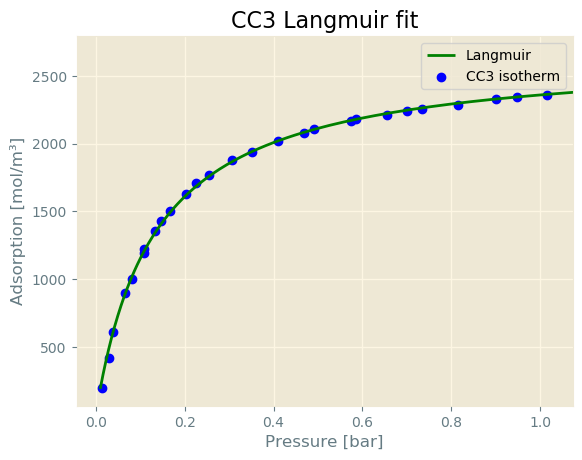

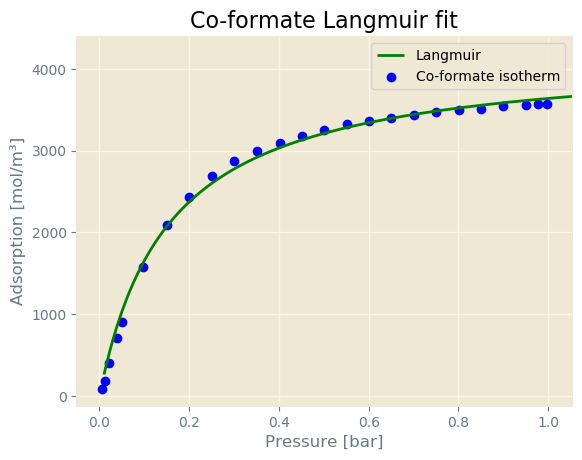

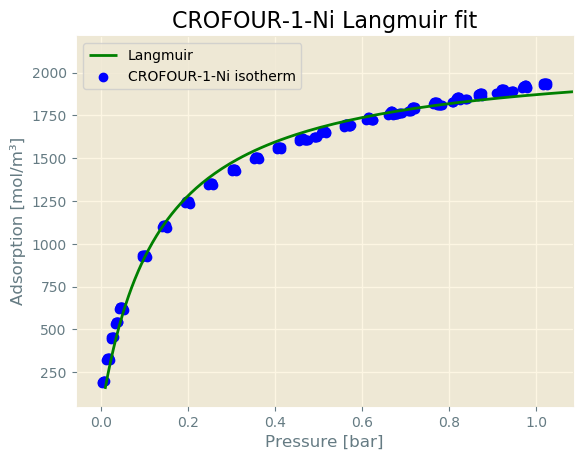

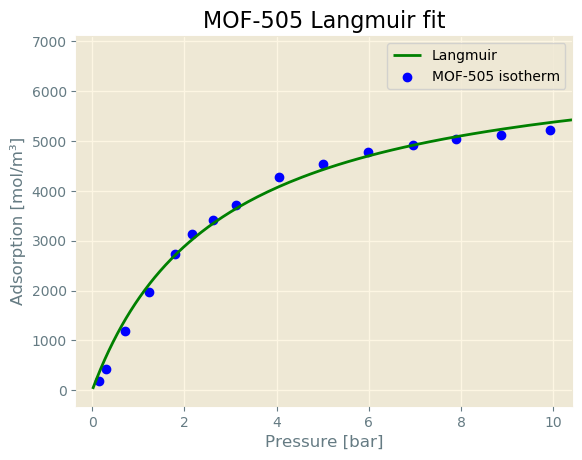

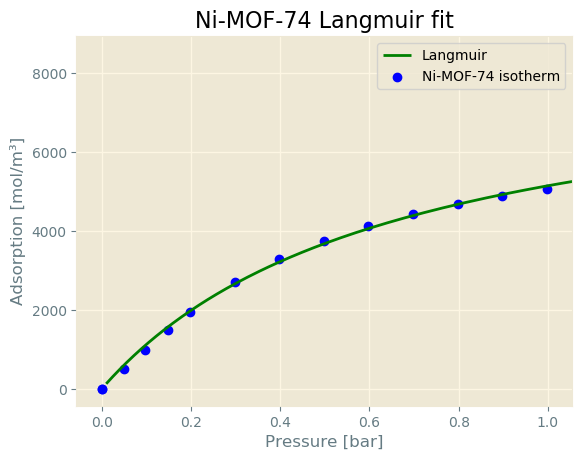

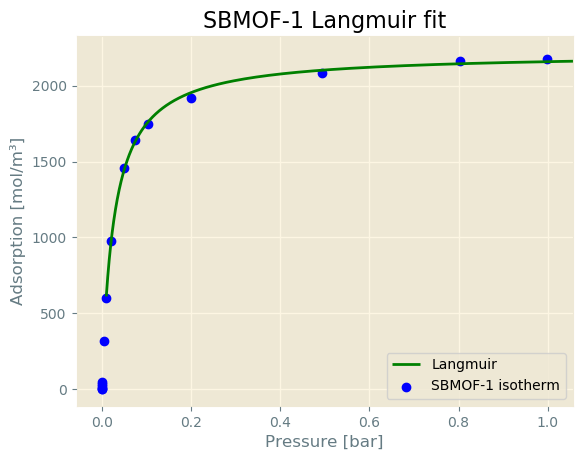

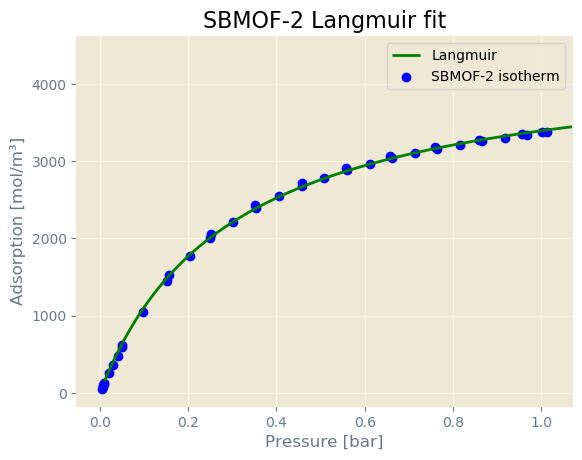

In [44]:
for crystal in crystals
    figure()
    ax = plt.gca()
    scatter(dict_isotherms[Base.basename(crystal, ".cif")][!, Symbol("P(bar)")],
            dict_isotherms[Base.basename(crystal, ".cif")][!, :mol_m3], color="b",
            label=Base.basename(crystal, ".cif") * " isotherm")
    lim = ax.get_xlim()
    plot(P, dict_aXe[Base.basename(crystal, ".cif")]["Density of gas in MOF (mol/m³)"], color="g",
            label="Langmuir")
    xlabel("Pressure [bar]")
    ylabel("Adsorption [mol/m³]")
    ax.set_xlim(lim)
    title(Base.basename(crystal, ".cif") * " Langmuir fit")
    legend()
    #savefig(Base.basename(crystal, ".cif") * " Langmuir fit")
end

## adsorbed xenon storage for each MOF

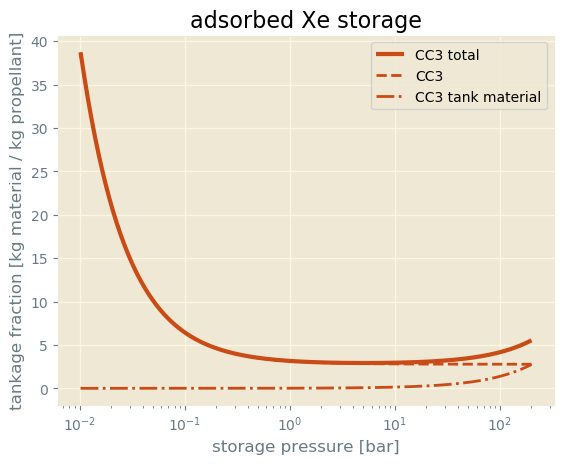

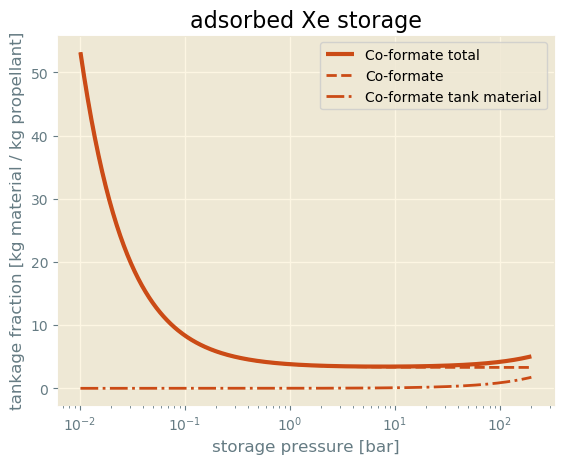

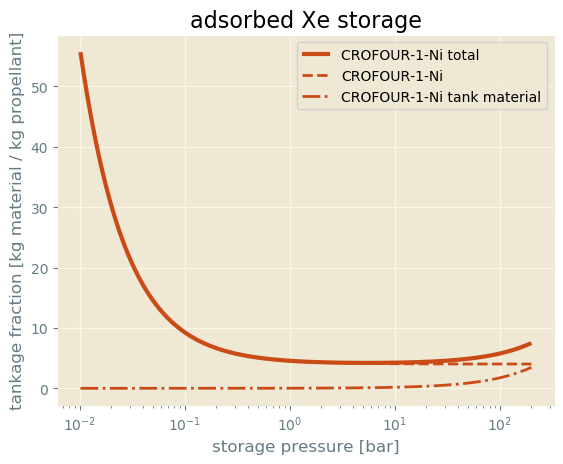

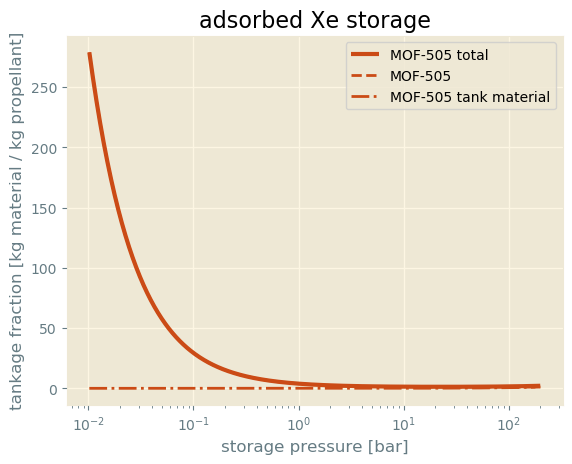

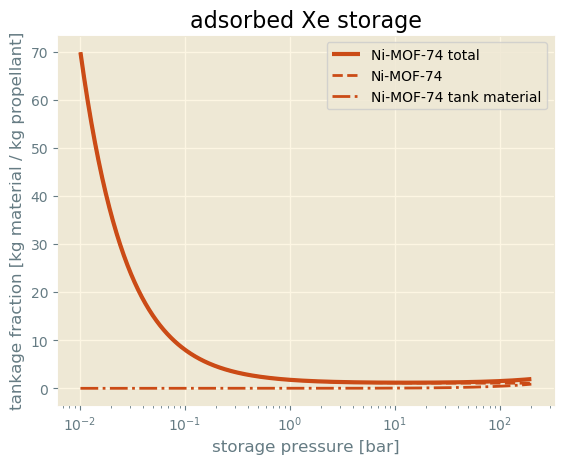

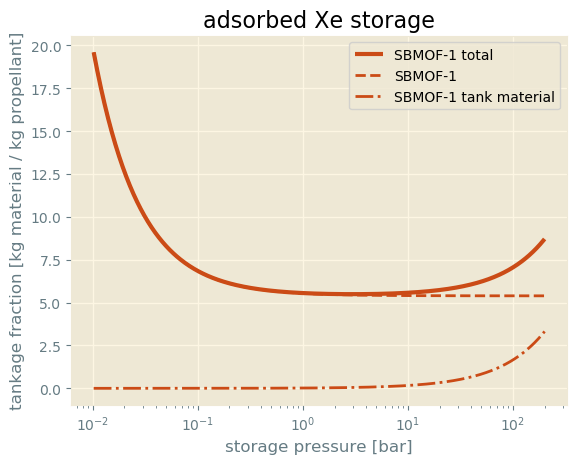

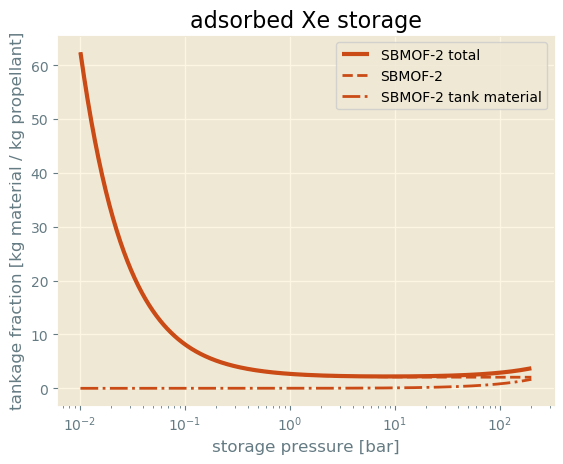

In [45]:
for crystal in crystals
    figure()
    plot(P, dict_aXe[Base.basename(crystal, ".cif")]["Mass of adsorbed Xe tank (kg)"] / 
        mass_desired_propellant, color="C4", lw=3, label=Base.basename(crystal, ".cif") * " total")
    plot(P, dict_aXe[Base.basename(crystal, ".cif")]["Mass of MOF with adsorbed Xe (kg)"] / 
        mass_desired_propellant, color="C4", label=Base.basename(crystal, ".cif"), linestyle="--")
    plot(P, dict_aXe[Base.basename(crystal, ".cif")]["Mass of tank material with adsorbed Xe (kg)"] / 
        mass_desired_propellant, color="C4", label=Base.basename(crystal, ".cif") * " tank material", linestyle="-.")
    xlabel("storage pressure [bar]")
    ylabel("tankage fraction [kg material / kg propellant]")
    title("adsorbed Xe storage")
    ax = gca()
    ax.set_xscale("log")
    legend()
end

## juxtapose compressed vs adsorbed xenon storage

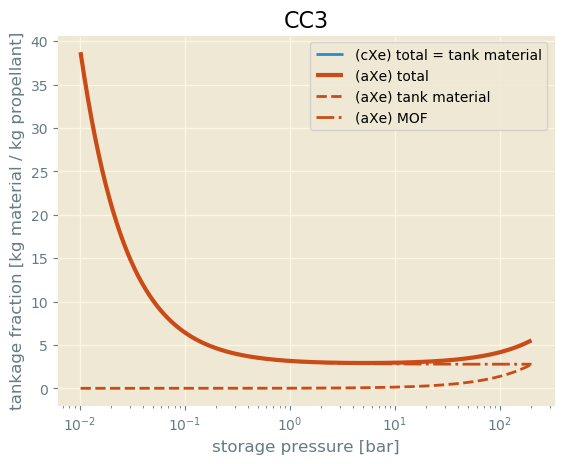

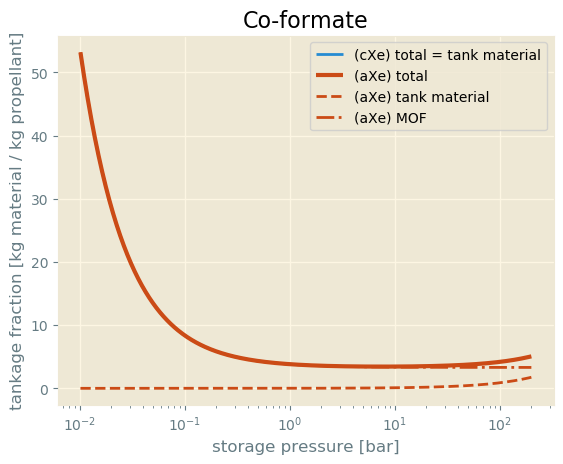

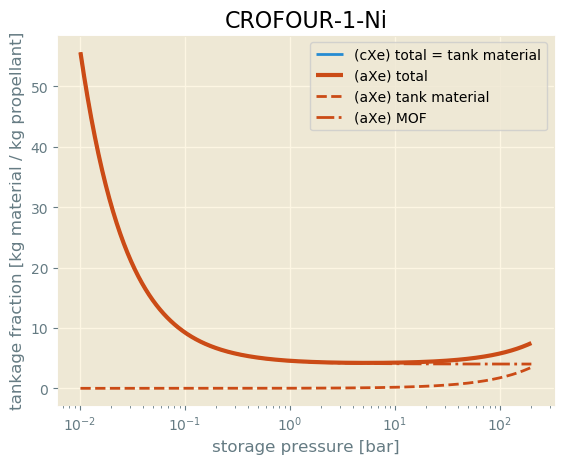

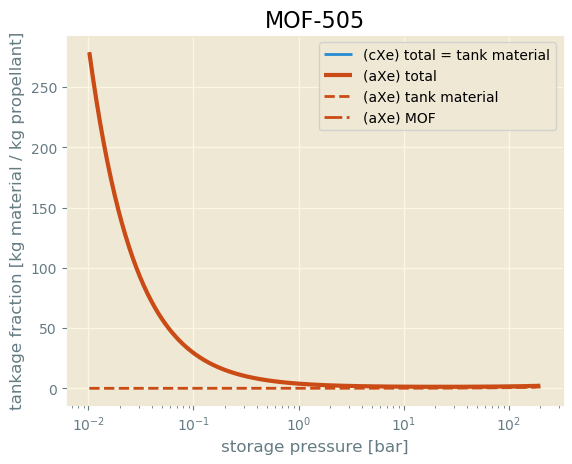

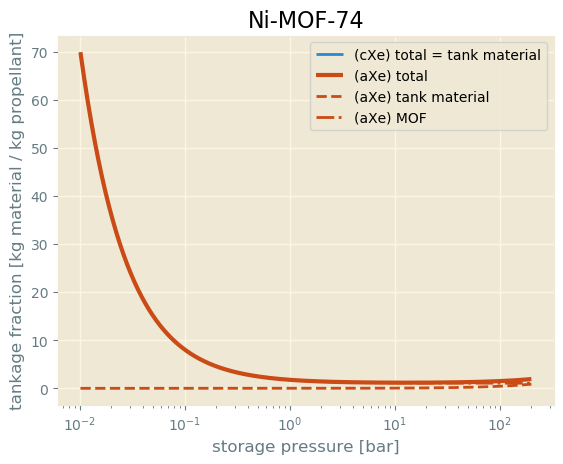

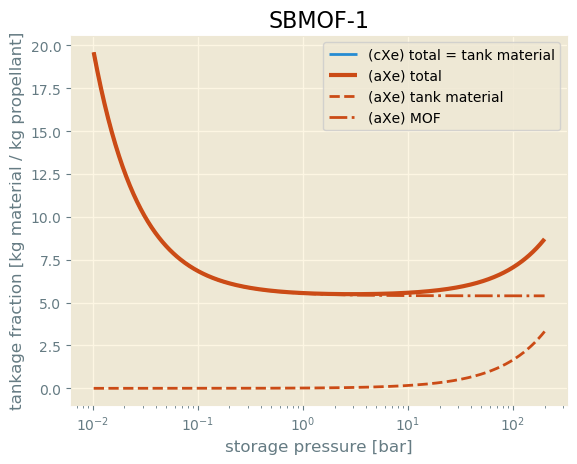

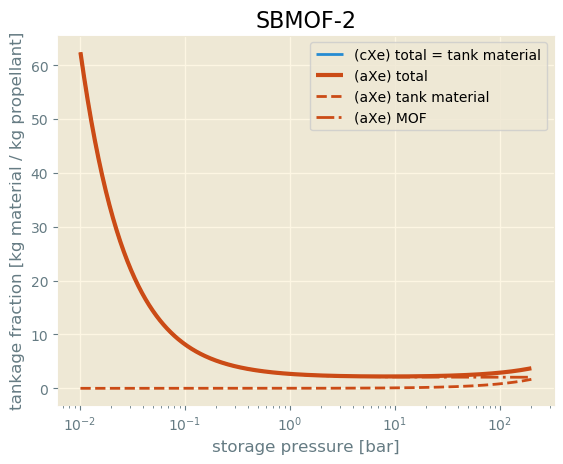

In [47]:
for crystal in crystals
    figure()
    plot(P, m_cXe_tank_material / mass_desired_propellant, color="C0", label="(cXe) total = tank material")

    plot(P, dict_aXe[Base.basename(crystal, ".cif")]["Mass of adsorbed Xe tank (kg)"] / 
        mass_desired_propellant, color="C4", lw=3, label="(aXe) total")
    plot(P, dict_aXe[Base.basename(crystal, ".cif")]["Mass of tank material with adsorbed Xe (kg)"] / mass_desired_propellant,
        color="C4", label="(aXe) tank material", linestyle="--")
    plot(P, dict_aXe[Base.basename(crystal, ".cif")]["Mass of MOF with adsorbed Xe (kg)"] / mass_desired_propellant,
        color="C4", label="(aXe) MOF", linestyle="-.")

    xlabel("storage pressure [bar]")
    ylabel("tankage fraction [kg material / kg propellant]")
    ax = gca()
    ax.set_xscale("log")
    title(Base.basename(crystal, ".cif"))
    legend()
    display()
end

## bulk gas density vs. MOF gas density

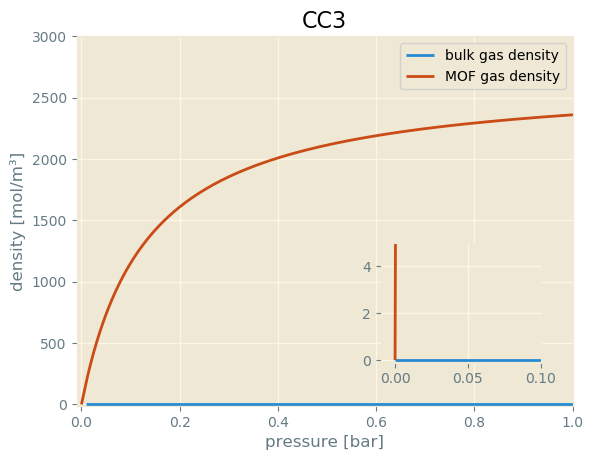

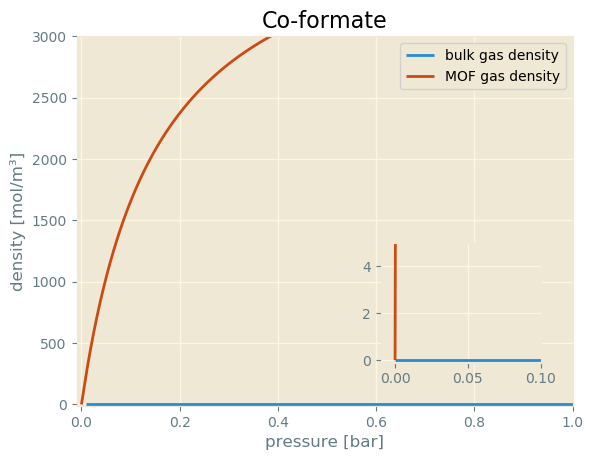

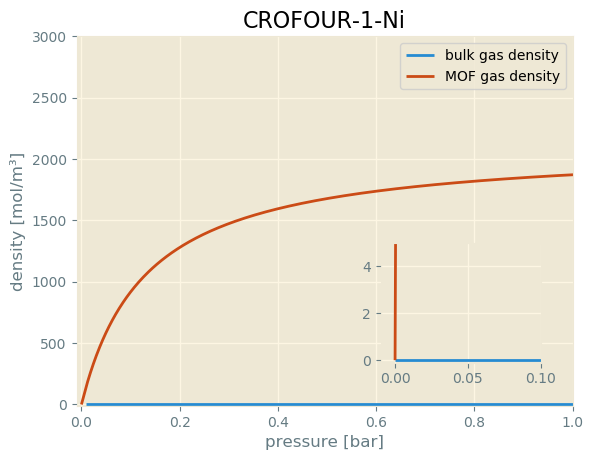

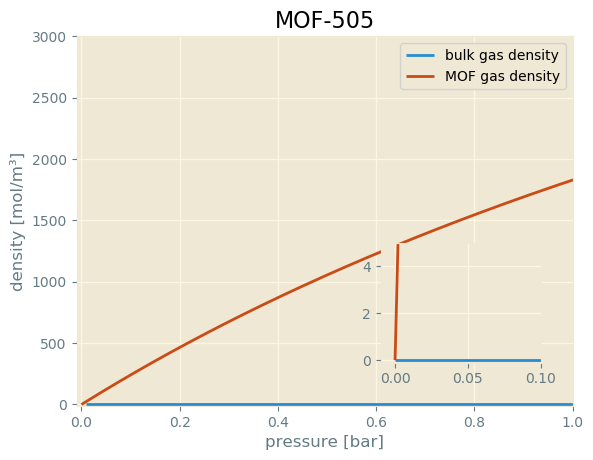

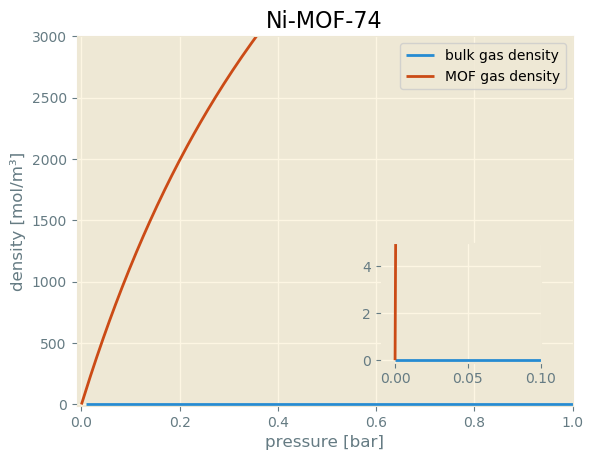

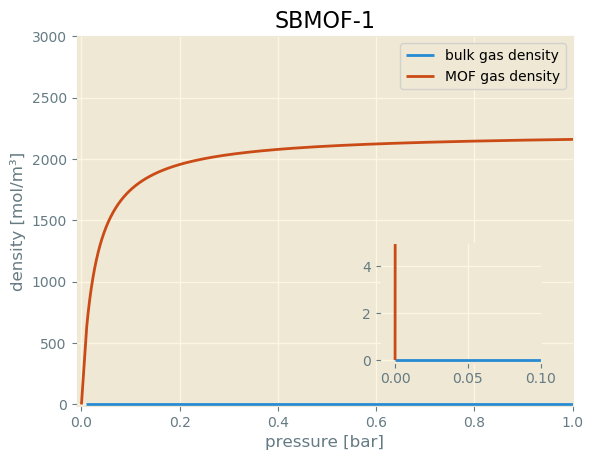

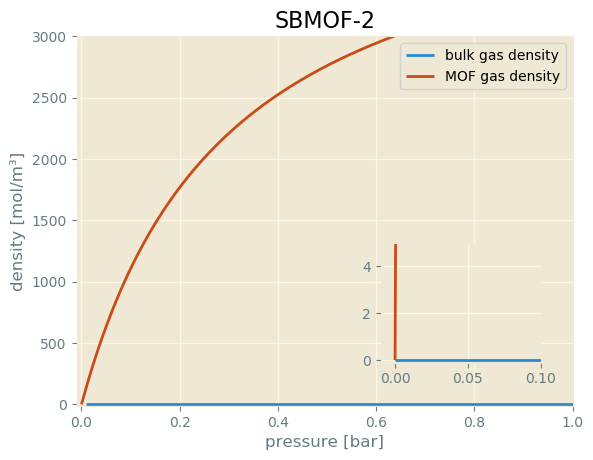

In [48]:
for crystal in crystals
    figure()
    ax = plt.gca()
    plot(P, ρ_vdw_gas, color="C0", label="bulk gas density")
    lim = ax.get_xlim()
    
    plot([0; P], [0; dict_aXe[Base.basename(crystal, ".cif")]["Density of gas in MOF (mol/m³)"]], 
        color="C4", label="MOF gas density")

    ylabel("density [mol/m³]")
    xlabel("pressure [bar]")
    ax.set_xlim(lim)
    legend()
    xlim(-0.01,1)
    ylim(-10,3000)
    display()
    title(Base.basename(crystal, ".cif"))
    
    a = plt.axes([.6, .2, .25, .25])
    a.plot([0; P], [0; ρ_vdw_gas], color="C0", label="bulk gas density")    
    a.plot([0; P], [0; dict_aXe[Base.basename(crystal, ".cif")]["Density of gas in MOF (mol/m³)"]], 
        color="C4", label="MOF gas density")
    a.set_xlim([-0.01, 0.1])
    a.set_ylim([-0.1, 5])
    #savefig(Base.basename(crystal, ".cif") * " gas density vs bulk gas density")
end

## xenon propellant storage performance

MOF and tank material performance

In [29]:
markers = ["D", "v", "1", "X", "s", "P", "*"]

figure()
scatter(P[cXe_minimum_index], (m_cXe_tank_material / mass_desired_propellant)[cXe_minimum_index], 
    color="y", label="(cXe) total = tank material")

for (i, crystal) in enumerate(crystals)
    scatter(P[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
            (dict_aXe[Base.basename(crystal, ".cif")]["Mass of adsorbed Xe tank (kg)"] / 
            mass_desired_propellant)[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
            lw=3, label="(aXe) " * Base.basename(crystal, ".cif"), marker=markers[i%(length(markers))+1])
end
xlabel("storage pressure [bar]")
ylabel("tankage fraction [kg material / kg propellant]")
legend()
title("MOF + tank material performance")


KeyError: KeyError: key "CROFOUR-1-Ni" not found

Tank material performance

In [30]:
figure()
scatter(P[cXe_minimum_index], (m_cXe_tank_material / mass_desired_propellant)[cXe_minimum_index], 
    color="y", label="(cXe) total = tank material")

for (i, crystal) in enumerate(crystals)
    scatter(P[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
            (dict_aXe[Base.basename(crystal, ".cif")]["Mass of tank material with adsorbed Xe (kg)"] / 
            mass_desired_propellant)[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
            lw=3, label="(aXe) " * Base.basename(crystal, ".cif"), marker=markers[i%(length(markers))+1])
end
xlabel("storage pressure [bar]")
ylabel("tankage fraction [kg material / kg propellant]")
legend()
title("Tank material performance")

# a = plt.axes([.6, .2, .25, .25])
# a.scatter(P[cXe_minimum_index], (m_cXe_tank_material / mass_desired_propellant)[cXe_minimum_index], 
#     color="y", label="(cXe) total = tank material")

# for (i, crystal) in enumerate(crystals)
#     a.scatter(P[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
#             (dict_aXe[Base.basename(crystal, ".cif")]["Mass of tank material with adsorbed Xe (kg)"] / 
#             mass_desired_propellant)[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
#             lw=3, label="(aXe) " * Base.basename(crystal, ".cif"), marker=markers[i%(length(markers))+1])
# end
# a.set_xlim([-1, 5])
# a.set_ylim([-0.01, 0.06])

KeyError: KeyError: key "CROFOUR-1-Ni" not found

Performance of radii of tanks

In [31]:
figure()
scatter(P[cXe_minimum_index], r_cXe_tank[cXe_minimum_index], 
    color="y", label="(cXe)tank")

for (i, crystal) in enumerate(crystals)
    scatter(P[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
            (dict_aXe[Base.basename(crystal, ".cif")]["Inner radius (m)"])[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
            lw=3, label="(aXe) " * Base.basename(crystal, ".cif"), marker=markers[i%(length(markers))+1])
end
xlabel("storage pressure [bar]")
ylabel("inner radius of tanks (m)")
legend()
title("Tank radius performance")

KeyError: KeyError: key "CROFOUR-1-Ni" not found

Performance of tank thickness

In [32]:
figure()
scatter(P[cXe_minimum_index], t_cXe_tank[cXe_minimum_index], 
    color="y", label="(cXe)tank")

for (i, crystal) in enumerate(crystals)
    scatter(P[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
            (dict_aXe[Base.basename(crystal, ".cif")]["Thickness of tank walls (m)"])[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
            lw=3, label="(aXe) " * Base.basename(crystal, ".cif"), marker=markers[i%(length(markers))+1])
end
xlabel("storage pressure [bar]")
ylabel("thickness of tanks (m)")
legend()
title("Tank thickness performance")

KeyError: KeyError: key "CROFOUR-1-Ni" not found

Performance of tank volume

In [33]:
figure()
scatter(P[cXe_minimum_index], V_cXe_tank[cXe_minimum_index], 
    color="y", label="(cXe)tank")

for (i, crystal) in enumerate(crystals)
    scatter(P[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
            (dict_aXe[Base.basename(crystal, ".cif")]["Inner volume of tank (m³)"])[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
            lw=3, label="(aXe) " * Base.basename(crystal, ".cif"), marker=markers[i%(length(markers))+1])
end
xlabel("storage pressure [bar]")
ylabel("volume of tank (m³)")
legend()
title("Tank inner volume performance")

KeyError: KeyError: key "CROFOUR-1-Ni" not found